In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
nltk.download('punkt', force=True)
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')
df_fake['label'] = 0
df_true['label'] = 1
df = pd.concat([df_fake, df_true], axis=0)
df = df[['text', 'label']].dropna().drop_duplicates()

In [4]:
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import nltk
from nltk.corpus import wordnet
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [6]:
df['clean_text'] = df['text'].apply(clean_text)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [9]:
X_train_text, X_test_text, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [10]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', C=0.5),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=17500/21000)
}

In [13]:
from sentence_transformers import SentenceTransformer

model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embed = model_sbert.encode(X_train_text.tolist(), convert_to_tensor=True).cpu().numpy()
X_test_embed = model_sbert.encode(X_test_text.tolist(), convert_to_tensor=True).cpu().numpy()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [14]:
clf = LogisticRegression(class_weight='balanced', max_iter=500)
clf.fit(X_train_embed, y_train)
y_pred = clf.predict(X_test_embed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3491
           1       0.96      0.97      0.96      4239

    accuracy                           0.96      7730
   macro avg       0.96      0.96      0.96      7730
weighted avg       0.96      0.96      0.96      7730



Accuracy: 0.9597671410090556

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      3491
           1       0.96      0.97      0.96      4239

    accuracy                           0.96      7730
   macro avg       0.96      0.96      0.96      7730
weighted avg       0.96      0.96      0.96      7730



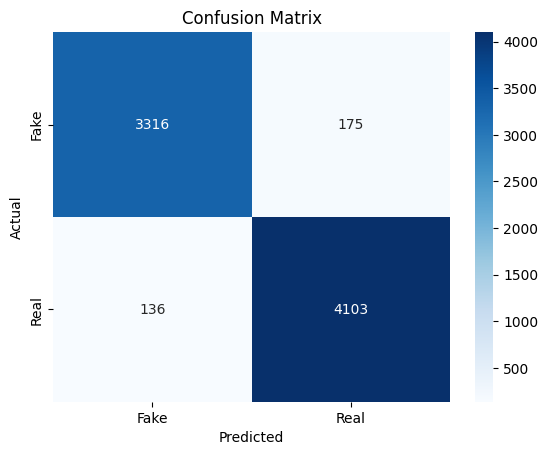

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = clf.predict(X_test_embed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
def predict_news(text):
    # Clean the input text exactly like your training data
    cleaned = clean_text(text)

    # Get BERT embedding
    embedded = model_sbert.encode([cleaned])

    # Predict
    pred = clf.predict(embedded)[0]
    proba = clf.predict_proba(embedded)[0]

    label = "Real" if pred == 1 else "Fake"
    print(f"Prediction: {label}")
    print(f"Confidence: Fake: {proba[0]*100:.2f}%, Real: {proba[1]*100:.2f}%")

# Example usage
sample_text = "The government has announced a new healthcare policy that will be rolled out in phases across the country."
predict_news(sample_text)


Prediction: Real
Confidence: Fake: 2.62%, Real: 97.38%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [17]:
# Sample real and fake news examples
test_samples = {
    "Real News 1": "The World Health Organization declared the end of the COVID-19 global health emergency on May 5th.",
    "Real News 2": "The Supreme Court ruled on Monday that states cannot ban same-sex marriage, expanding equal rights nationwide.",
    "Real News 3": "NASA's Artemis I mission successfully completed its lunar orbit and returned safely to Earth this weekend.",
    "Fake News 1": "Bill Gates has been arrested for creating a chip in vaccines to control the population.",
    "Fake News 2": "Scientists discover that the moon is hollow and houses secret alien bases.",
    "Fake News 3": "The government is replacing currency with invisible crypto chips implanted in citizens' hands.",
}

# Run predictions on all samples
for title, text in test_samples.items():
    print(f"\n📰 {title}")
    predict_news(text)



📰 Real News 1
Prediction: Real
Confidence: Fake: 3.18%, Real: 96.82%

📰 Real News 2
Prediction: Real
Confidence: Fake: 36.57%, Real: 63.43%

📰 Real News 3
Prediction: Real
Confidence: Fake: 3.81%, Real: 96.19%

📰 Fake News 1
Prediction: Real
Confidence: Fake: 44.26%, Real: 55.74%

📰 Fake News 2
Prediction: Fake
Confidence: Fake: 59.27%, Real: 40.73%

📰 Fake News 3
Prediction: Fake
Confidence: Fake: 92.19%, Real: 7.81%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

In [18]:
import joblib
joblib.dump(clf, 'bert_fake_news_model.pkl')


['bert_fake_news_model.pkl']